Import required modules

In [1]:
import pydicom
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
import pandas as pd


Access the folder path for the cancer and the non-cancer images

In [2]:
personal_path = "/Users/theon/Documents/Classes/Computing/CISC 471/Data"
non_cancerous_path = personal_path + "/Non-Cancerous-Images/abdominallymphnodes-26828"
non_cancerous_annotations_path = personal_path + "/Non-Cancerous-Images/Annotations-26828"
cancerous_path = personal_path + "/Cancerous-Images/NA-78735"
cancerous_annotations_path = personal_path + "/Cancerous-Images/Annotations-78735"

In [12]:

def load_dicom_images(folder_path):
    images = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".dcm"):
            path = os.path.join(folder_path, file_name)
            dicom_data = pydicom.dcmread(path)
            images.append(dicom_data.pixel_array)
    return images

non_cancerous_images = load_dicom_images(non_cancerous_path)
non_cancerous_annotated_images = load_dicom_images(non_cancerous_annotations_path)
cancerous_images = load_dicom_images(cancerous_path)
cancerous_annotated_images = load_dicom_images(cancerous_annotations_path)

In [13]:

print("Non-cancerous images loaded:", len(non_cancerous_images))
print("Annotated non-cancerous images loaded:", len(non_cancerous_annotated_images))
print("Cancerous images loaded:", len(cancerous_images))
print("Annotated cancerous images loaded:", len(cancerous_annotated_images))

Non-cancerous images loaded: 661
Annotated non-cancerous images loaded: 1
Cancerous images loaded: 134
Annotated cancerous images loaded: 1


DICOM to JPG

In [40]:
def convert_to_jpg(images, output_folder):
    for i, img in enumerate(images):
        img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img_uint8 = img_normalized.astype("uint8")
        cv2.imwrite(f"{output_folder}/image_{i}.jpg", img_uint8)


def convert_annotations_to_jpg(images, output_folder):
    for img in images:
        # grayscale the image
        img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img_uint8 = img_normalized.astype("uint8")
        # since this is a 3d array, make a separate image for each layer in the 1st plane
        for i, j in enumerate(img_uint8):
            cv2.imwrite(f"{output_folder}/image_{i}.jpg", j)

convert_to_jpg(cancerous_images, cancerous_path + "/images")
convert_to_jpg(non_cancerous_images, non_cancerous_path + "/images")
convert_annotations_to_jpg(cancerous_annotated_images, cancerous_annotations_path + "/images")
convert_annotations_to_jpg(non_cancerous_annotated_images, non_cancerous_annotations_path + "/images")

Load in annotations for non_cancerous tissue

[(243, 228, 366), (226, 221, 366), (276, 239, 370), (309, 268, 418)]
here


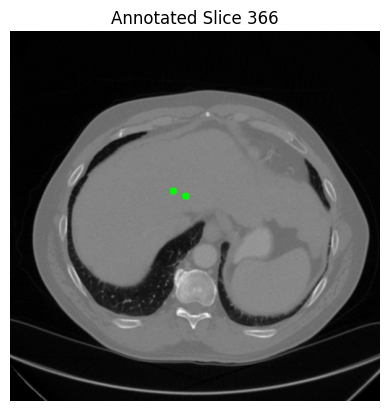

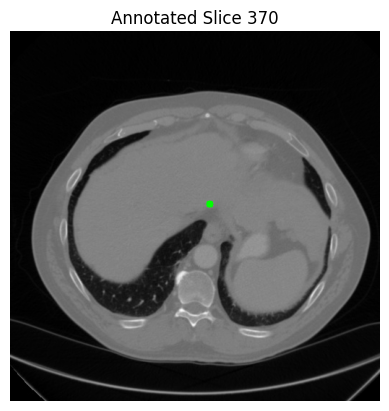

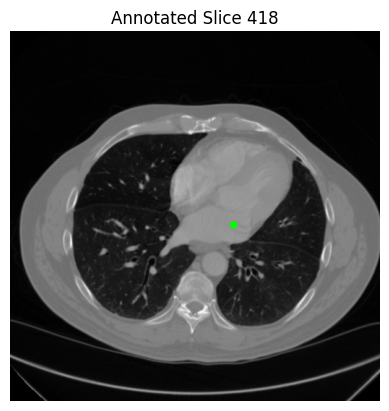

In [13]:
# Load voxel indices from TXT file
def load_voxel_indices(file_path):
    voxel_points = []
    with open(file_path, 'r') as f:
        for line in f:
            x, y, z = map(int, line.strip().split())
            voxel_points.append((x, y, z))
    return voxel_points

# Overlay voxel points on an image
def overlay_voxel_points(image, points):
    for x, y, _ in points:  # Only use x and y
        image = cv2.circle(image, (x, y), 5, (0, 255, 0), -1)  # Green circle
    return image

# Process JPG images in folder
def process_jpg_with_voxel_annotations(image_folder, voxel_file, output_folder, display_limit=5):
    # Load voxel indices
    voxel_points = load_voxel_indices(voxel_file)
    print(voxel_points)
    # Counter for the number of displayed images
    images_displayed = 0

    # Iterate through JPG images in the folder
    for slice_idx, file_name in enumerate(sorted(os.listdir(image_folder))):
        if file_name.endswith(".jpg"):
            # Load the image
            image_path = os.path.join(image_folder, file_name)
            image = cv2.imread(image_path)

            # Filter points for the current slice
            slice_points = [(x, y, z) for x, y, z in voxel_points if z == slice_idx]
            if slice_idx == 366:
                print('here')

            annotated_image = overlay_voxel_points(image, slice_points)

            # Save the annotated image
            output_path = os.path.join(output_folder, f"annotated_{file_name}")
            cv2.imwrite(output_path, annotated_image)

            # Display the annotated image only if we haven't reached the display limit
            if (images_displayed < display_limit and slice_points):
                plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
                plt.title(f"Annotated Slice {slice_idx}")
                plt.axis('off')
                plt.show()
                images_displayed += 1  # Increment the display counter
        
   
# Usage
image_folder = non_cancerous_path + "/images"  # Folder with JPG files
voxel_file = non_cancerous_annotations_path + "/ABD_LYMPH_001_lymphnodes_indices.txt"  # Voxel indices file
output_folder = personal_path + "/annotated_non-cancerous_images"  # Folder to save annotated images 
os.makedirs(output_folder, exist_ok=True)

process_jpg_with_voxel_annotations(image_folder, voxel_file, output_folder)




Preprocess Images for CNN

In [45]:
#Resize images
def preprocess_image(img, target_size=(224, 224)):
    img_resized = cv2.resize(img, target_size)
    return img_resized

non_cancerous_images_resized = [preprocess_image(img) for img in non_cancerous_images]
cancerous_images_resized = [preprocess_image(img) for img in cancerous_images]


#Normalization
non_cancerous_images_normalized = [img / 255.0 for img in non_cancerous_images_resized]
cancerous_images_normalized = [img / 255.0 for img in cancerous_images_resized]


CNN

In [46]:


X = non_cancerous_images_normalized + cancerous_images_normalized
y = [0] * len(non_cancerous_images_normalized) + [1] * len(cancerous_images_normalized)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Convert lists to arrays
X_train = np.array(X_train).reshape(-1, 224, 224, 1)  # Add channel dimension if grayscale
X_test = np.array(X_test).reshape(-1, 224, 224, 1)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [47]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (636, 224, 224, 1)
X_test shape: (159, 224, 224, 1)
y_train shape: (636,)
y_test shape: (159,)


In [48]:
X_train

array([[[[-4.01568627],
         [-4.01568627],
         [-4.01568627],
         ...,
         [-4.01568627],
         [-4.01568627],
         [-4.01568627]],

        [[-4.01568627],
         [-4.01568627],
         [-4.01568627],
         ...,
         [-4.01568627],
         [-4.01568627],
         [-4.01568627]],

        [[-4.01568627],
         [-4.01568627],
         [-4.01568627],
         ...,
         [-4.01568627],
         [-4.01568627],
         [-4.01568627]],

        ...,

        [[-4.01568627],
         [-4.01568627],
         [-4.01568627],
         ...,
         [-4.01568627],
         [-4.01568627],
         [-4.01568627]],

        [[-4.01568627],
         [-4.01568627],
         [-4.01568627],
         ...,
         [-4.01568627],
         [-4.01568627],
         [-4.01568627]],

        [[-4.01568627],
         [-4.01568627],
         [-4.01568627],
         ...,
         [-4.01568627],
         [-4.01568627],
         [-4.01568627]]],


       [[[-4.01568627],


In [49]:
X_test

array([[[[-7.84313725],
         [-7.84313725],
         [-7.84313725],
         ...,
         [-7.84313725],
         [-7.84313725],
         [-7.84313725]],

        [[-7.84313725],
         [-7.84313725],
         [-7.84313725],
         ...,
         [-7.84313725],
         [-7.84313725],
         [-7.84313725]],

        [[-7.84313725],
         [-7.84313725],
         [-7.84313725],
         ...,
         [-7.84313725],
         [-7.84313725],
         [-7.84313725]],

        ...,

        [[-7.84313725],
         [-7.84313725],
         [-7.84313725],
         ...,
         [-7.84313725],
         [-7.84313725],
         [-7.84313725]],

        [[-7.84313725],
         [-7.84313725],
         [-7.84313725],
         ...,
         [-7.84313725],
         [-7.84313725],
         [-7.84313725]],

        [[-7.84313725],
         [-7.84313725],
         [-7.84313725],
         ...,
         [-7.84313725],
         [-7.84313725],
         [-7.84313725]]],


       [[[-7.84313725],


In [50]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [51]:
y_test

array([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0])

In [52]:
train_test_split(y, shuffle=False)

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


Check Class Distribution in Train and Test Sets

In [53]:

# Assuming y_train and y_test are your labels for the train and test sets
train_class_distribution = pd.Series(y_train).value_counts(normalize=True)
test_class_distribution = pd.Series(y_test).value_counts(normalize=True)

print("Class distribution in training set:")
print(train_class_distribution)
print("\nClass distribution in testing set:")
print(test_class_distribution)

Class distribution in training set:
0    0.836478
1    0.163522
Name: proportion, dtype: float64

Class distribution in testing set:
0    0.811321
1    0.188679
Name: proportion, dtype: float64
